In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf 
from pinnPack.network import physicsNetwork
from pinnPack.initializer import genData
from pinnPack.optimizer import pinnOptimizer

2025-03-11 13:34:49.140377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-11 13:34:49.830924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Initializing Collocation Point

In [2]:
#Initial pulse function
def sechPulse(time, amplitude, pulse_width, T):
    time = time
    return amplitude/np.cosh(time*T/pulse_width)

pulsewidth = 0.1*2**7 

#Fiber parameter
gamma = 10 
beta2 = -100 
alpha = 0.2*np.log(10)/10 

z_char = np.pi/2*pulsewidth**2/np.abs(beta2)
length = 1.5*z_char 

#initial pulse
N = 1
A = np.sqrt(np.abs(beta2)/gamma/pulsewidth**2)

In [3]:
T = 60
L = length 

start_point = np.array([-1, 0]) #(t,x) = (-1,0)
final_point = np.array([1, 1]) #(t,x) = (1,1)

#Declaring numbers of collocation points and labelled points 
col_points = 20000
label_points = 5000

In [4]:
t_initial = genData.generate_points(final_point[0], start_point[0], label_points)
x_boundary = genData.generate_points(final_point[-1], start_point[-1], label_points)

#initial condition (x = 0)
initial_tx = np.c_[t_initial, 
                   np.zeros((label_points, 1))]
u_init = sechPulse(initial_tx[..., 0], A, pulsewidth, T).reshape(-1,1) #real part
initial_uv = np.c_[u_init, np.zeros_like(u_init)]

#lower boundary condition (t = t_init)
lower_tx = np.c_[np.full((label_points, 1), start_point[0]),
                 x_boundary]
lower_uv = np.zeros((label_points, 2))

#upper boundary condition (t = t_f)
upper_tx = np.c_[np.full((label_points, 1), final_point[0]),
                 x_boundary]
upper_uv = np.zeros((label_points, 2)) 

#collocation point 
col_point = genData.generate_points(final_point, start_point, col_points)
col_uv = np.zeros((col_points, 2)) 

#labelled point 
label_point = np.concatenate([initial_tx, lower_tx, upper_tx]) 
label_uv = np.concatenate([initial_uv, lower_uv, upper_uv])

In [5]:
label_data = genData.batch_data(label_point, label_uv) 
col_data = genData.batch_data(col_point, col_uv)

2025-03-11 13:34:57.266328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8153 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0


# Initializing Model

In [6]:
model = physicsNetwork.build(layers = [64,64,64])

# Fit Model

In [7]:
optimizer = pinnOptimizer(model, col_data, label_data, T, L, alpha, beta2, gamma)
optimizer.fit(adam_epochs = 500, bfgs_epochs = 10)

Adam_Epochs:   0% 0/500 [00:00<?, ?epoch/s]
LBFGS_Epochs:   0% 0/10 [00:00<?, ?epoch/s]

Processing using ADAM Optimalization strategies


2025-03-11 13:35:02.705949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Adam_Epochs: 100% 500/500 [00:14<00:00, 33.90epoch/s, loss=4.3819e-04]


Processing using L-BFGS Optimalization strategies



LBFGS_Epochs:   0% 0/10 [00:16<?, ?epoch/s, loss=4.3721e-04]
LBFGS_Epochs:  10% 1/10 [00:16<02:31, 16.80s/epoch, loss=4.3721e-04]
LBFGS_Epochs:  10% 1/10 [00:18<02:31, 16.80s/epoch, loss=2.9079e-04]
LBFGS_Epochs:  20% 2/10 [00:18<01:03,  7.95s/epoch, loss=2.9079e-04]
LBFGS_Epochs:  20% 2/10 [00:20<01:03,  7.95s/epoch, loss=1.7058e-04]
LBFGS_Epochs:  30% 3/10 [00:20<00:36,  5.15s/epoch, loss=1.7058e-04]
LBFGS_Epochs:  30% 3/10 [00:22<00:36,  5.15s/epoch, loss=1.1660e-04]
LBFGS_Epochs:  40% 4/10 [00:22<00:22,  3.82s/epoch, loss=1.1660e-04]
LBFGS_Epochs:  40% 4/10 [00:23<00:22,  3.82s/epoch, loss=9.4524e-05]
LBFGS_Epochs:  50% 5/10 [00:23<00:15,  3.09s/epoch, loss=9.4524e-05]
LBFGS_Epochs:  50% 5/10 [00:25<00:15,  3.09s/epoch, loss=8.4041e-05]
LBFGS_Epochs:  60% 6/10 [00:25<00:10,  2.65s/epoch, loss=8.4041e-05]
LBFGS_Epochs:  60% 6/10 [00:27<00:10,  2.65s/epoch, loss=8.0540e-05]
LBFGS_Epochs:  70% 7/10 [00:27<00:07,  2.36s/epoch, loss=8.0540e-05]
LBFGS_Epochs:  70% 7/10 [00:29<00:07,  2.

In [8]:
t_array = np.linspace(start_point[0], final_point[0], 100)
zlocs = np.linspace(start_point[1], final_point[1], 500)
T, Z = np.meshgrid(t_array, zlocs)
tZ = np.stack((T.flatten(), Z.flatten()), axis = -1)

result = model.predict(tZ)

result_u = result[:, 0].reshape(Z.shape)
result_v = result[:, 1].reshape(Z.shape)


1563/1563 [==============================] - 1s 649us/step


In [9]:
result_P = (result_u**2 + result_v**2)

# Visualize Data

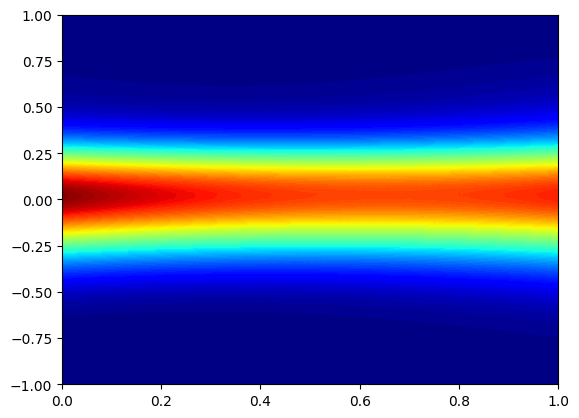

In [10]:
plt.contourf(Z,T, result_P, 100, cmap = 'jet')

In [11]:
from matplotlib import cm

Text(0.5, 0.92, 'Propagation of Pulse in Non-Linear Optical Fiber via PINN')

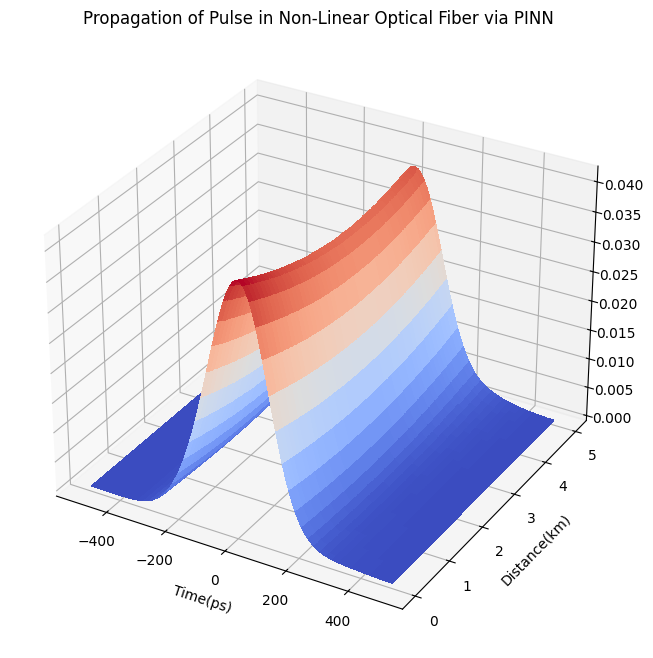

In [12]:
fig, ax = plt.subplots(figsize = (10,8), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(T*500, Z*5, result_P, cmap = cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('Time(ps)')
ax.set_ylabel('Distance(km)')
ax.set_title('Propagation of Pulse in Non-Linear Optical Fiber via PINN')

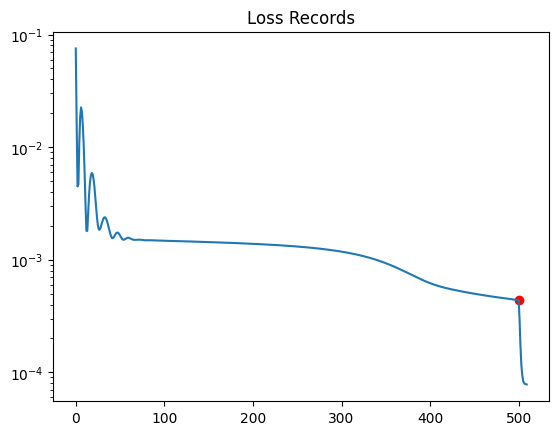

In [28]:
plt.plot(optimizer.loss_records)
plt.scatter(500, optimizer.loss_records[500], color = 'red')
plt.title('Loss Records')
plt.yscale('log')

Text(0.5, 1.0, 'Time Records')

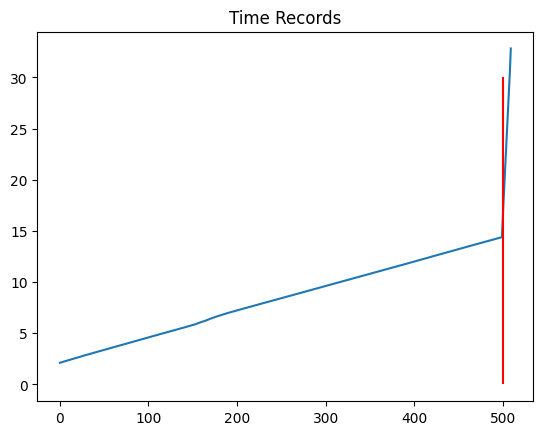

In [24]:
plt.plot(optimizer.time_records)
plt.vlines(500, 0, 30, color = 'red')
plt.title('Time Records')